In [1]:
#------------   Sawyer Smith   -----------------

# This is a 10 panel plotting script that plots IVT, a user defined axis and corresponding perpendicular cross section transects
import numpy as np
from netCDF4 import Dataset
import matplotlib.pyplot as plt
from wrf import to_np, getvar, CoordPair, vertcross, latlon_coords,interpline, interplevel, get_cartopy,  xy_to_ll, ll_to_xy, smooth2d
import wrf
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors
from matplotlib.cm import get_cmap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from scipy.interpolate import interp1d
import glob
import xarray as xr
from scipy.ndimage import gaussian_filter
from matplotlib.cm import get_cmap
from statistics import multimode, mode
from datetime import datetime
import os
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

In [2]:
datafiles = (glob.glob(f"/scratch/sawyer/wwrf/2017-01-09/ishmael/wrfout_d01_2017-01-08_06:00:00"))
datafiles.sort()
numfiles=len(datafiles)
ncfile = Dataset(datafiles[0])
p = getvar(ncfile, "pressure")
# Get the lat/lon coordinates
wrf_lats, wrf_lons = latlon_coords(p)

## WWRF longitude fix ######
new_lons =np.where(wrf_lons > 0, wrf_lons - 360, wrf_lons)

In [3]:
hour = '15'
day = 8
# Initialize an empty list to store the filtered ivt arrays
ivt_list = []
slp_list = []
# Get a list of all .npy files in the directory
ivt_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_*_2017010{day}_{hour}.npy')
slp_paths = glob.glob(f'/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_*_2017010{day}_{hour}.npy')
# Sort the file paths alphabetically
sorted_ivt_paths = sorted(ivt_paths)
# Loop through each file and load, filter, and append the data
for ivt in sorted_ivt_paths:
    print(ivt)
    ivt_arrays = np.load(ivt, allow_pickle=True)
    ivt_copy = ivt_arrays.copy()
    #ivt_copy = gaussian_filter(ivt_copy, 3)
    ivt_list.append(ivt_copy)
    
sorted_slp_paths = sorted(slp_paths)
# Loop through each file and load, filter, and append the data
for file in sorted_slp_paths:
    print(file)
    slp_arrays = np.load(file, allow_pickle=True)
    slp = slp_arrays.copy()
    slp_array = gaussian_filter(slp, 3)
    slp_list.append(slp_array)

/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_ishamel_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_ntu_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_p3_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_p3_2nd_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_p3_2xcloud_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_p3mom_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_thompson_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_thopmson_aa_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_wdm6_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/total_ivt/ivt_wsm6_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_ishamel_20170108_15.npy
/scratch/sawyer/wwrf/2017-01-09/ensemble_data/slp/slp_ntu_20170108_15.npy
/scratch/sawyer/ww

In [4]:
# Function to plot a line at a specified angle and midpoint, modified to return endpoints
def get_axis_coords(midpoint, length, angle_degrees):
    x_mid, y_mid = midpoint
    angle_radians = np.radians(angle_degrees)

    # Calculate delta x and delta y based on the angle
    delta_x = (length / 2) * np.cos(angle_radians)
    delta_y = (length / 2) * np.sin(angle_radians)

    # Calculate the endpoints
    x1, y1 = x_mid - delta_x, y_mid - delta_y
    x2, y2 = x_mid + delta_x, y_mid + delta_y

    return [x1, y1, x2, y2]

In [5]:
lon_mid = -130
lat_mid = 30
length = 25
angle = 45
axis = get_axis_coords((lon_mid,lat_mid),length,angle)
#print(axis[0])
#print(axis[2])
x1, x2 = axis[0], axis[2]
y1, y2 = axis[1], axis[3]
# Calculate the slope of the original line
slope = (y2 - y1) / (x2 - x1)

# Calculate the negative reciprocal (perpendicular slope)
perp_slope = -1 / slope if slope != 0 else float('inf')  # Check for vertical line

# Use np.linspace to calculate midpoints
# make adjustments to midpoint slider below; (e.g. to slide further northeast, slider would corresponde to values > 0.5
# 0.5 is midpoint of axis
slider = 0.49#0.49
width = 0.017
num = 40
midpoints_x = np.linspace((x1 + x2) * (slider - width), (x1 + x2) * (slider + width), num=num)

# Define the length of each perpendicular line from its midpoint
southern_perp_line_length = 4.5
northern_perp_line_length = 10.
# Prepare a list to store the endpoints of each perpendicular line
perpendicular_line_endpoints = []
# Iterate through the calculated midpoints
for mid_x in midpoints_x:
    mid_y = (mid_x - x1) * slope + y1  # Calculate corresponding mid_y based on the original line's slope

    # Define the x-range for the perpendicular line to ensure it's within the grid
    if perp_slope != float('inf'):  # Regular case, not a vertical line
        x_range = np.linspace(mid_x - northern_perp_line_length, mid_x + southern_perp_line_length, 2)
        # Define the perpendicular line's y-coordinates based on the perpendicular slope
        y_perp = perp_slope * (x_range - mid_x) + mid_y
    else:  # Special case for a vertical line
        x_range = [mid_x, mid_x]
        y_perp = [mid_y - perp_line_length, mid_y + perp_line_length]

    # Store the start and end points of the perpendicular line
    start_point = (x_range[0], y_perp[0])
    end_point = (x_range[1], y_perp[1])
    perpendicular_line_endpoints.append((start_point, end_point))


In [6]:
# Assuming your 'perpendicular_line_endpoints' list is already populated

# Access the first start_point and end_point
first_start_point, first_end_point = perpendicular_line_endpoints[0]

# Access the last start_point and end_point
last_start_point, last_end_point = perpendicular_line_endpoints[-1]

# Print out the first and last start and end points
print("First start point:", first_start_point)
print("First end point:", first_end_point)
print("Last start point:", last_start_point)
print("Last end point:", last_end_point)

First start point: (-132.98, 47.02000000000002)
First end point: (-118.47999999999999, 32.52000000000001)
Last start point: (-141.82, 38.18000000000002)
Last end point: (-127.32, 23.68000000000001)


In [7]:
########### Define the colors in the desired sequence for IVT: ###########

colors = ['#FFFF00', '#FFEE00','#FFDC00', '#FFB700',
          '#FFA300', '#FF9000', '#FF7D00', '#FF6800',
          '#FF5200', '#C70039','#900C3F', (.88,.24,.69)]

############## Create a colormap using ListedColormap #################

cmap = mcolors.ListedColormap(colors)
pmsl_levels = np.arange(960, 1060, 4)
# dark brown for state/coastlines
dark_brown = (0.4, 0.2, 0)
ivt_levels = np.arange(250,1150,100)

# Make a list of title for plotting
titles = ['Ishmael','NTU','P3','P3 2nd', 'P3 2X', 'P3 3-mom',
          'Thompson', 'Thompson AA', 'WDM6', 'WSM6']

0
1
2
3
4
5
6
7
8
9


/tmp/ipykernel_51657/854557687.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0.03, 1, 0.95])


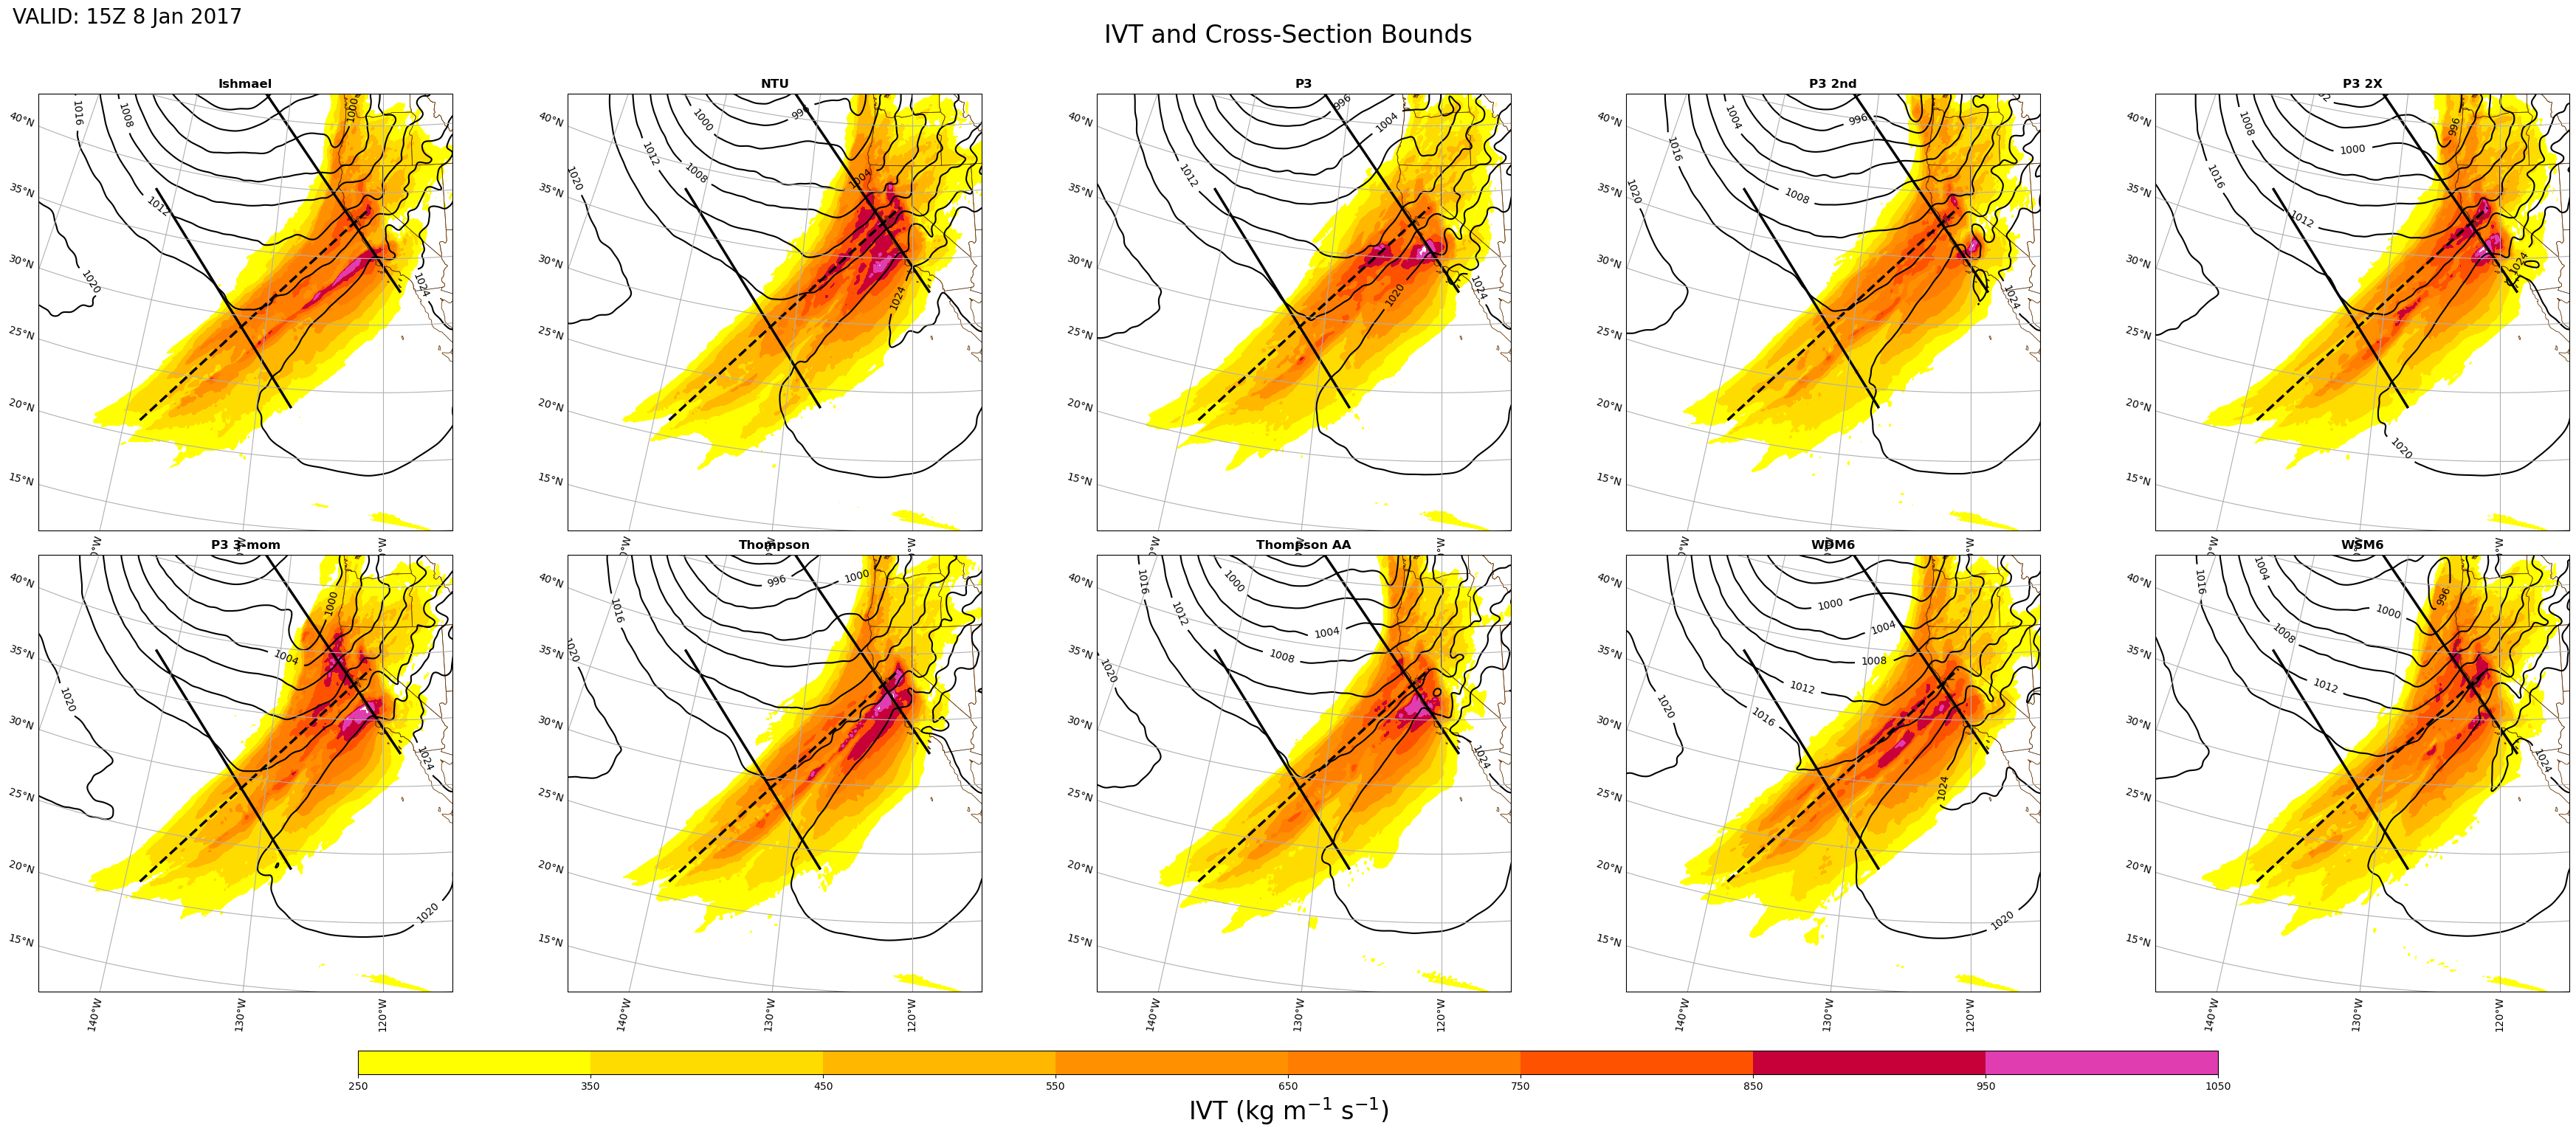

In [8]:
# Get the cartopy mapping object
lcc_projection = ccrs.LambertConformal(
    central_longitude=-120.0)
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(36, 16),
                        subplot_kw={'projection': lcc_projection})
axs = axs.ravel()  # Flatten axs

# Loop through the first N-1 elements
for i in range(len(slp_list)):#
    ax = axs[i]
    print(i)
    ax.set_title(titles[i], fontweight='bold')

    """
    Plot AR IVT to get an idea of horizontal placement, and overlay the coordinates of our cross section.
    """
    ax.set_extent([-145, -115, 15, 45])
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.5, edgecolor=dark_brown)
    ax.coastlines('50m', linewidth=0.6, color=dark_brown)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linestyle=':', linewidth=0.5)#Add coastlines


    cs = ax.contourf(to_np(new_lons), to_np(wrf_lats), to_np(ivt_list[i]), cmap = cmap, levels = ivt_levels, transform=ccrs.PlateCarree())
    cp = ax.contour(to_np(new_lons), to_np(wrf_lats), to_np(slp_list[i]), colors='black', levels = pmsl_levels, transform=ccrs.PlateCarree())
    ax.clabel(cp, fmt='%1.0f', inline=True,levels=pmsl_levels)
    ax.plot([x1, x2], [y1,y2], color = 'black', linewidth=2.5,linestyle='--', transform=ccrs.PlateCarree())
    #ax.plot(x_range, y_perp, label='Perpendicular Line',color = 'black', transform=ccrs.PlateCarree())
    #ax.plot([x_range[0],x_range[-1]], [y_perp[0],y_perp[-1]], label='Perpendicular Line',color = 'black', transform=ccrs.PlateCarree())
    # Plot each perpendicular line
       # Plot only the first and last perpendicular lines
    ax.plot([first_start_point[0], first_end_point[0]], [first_start_point[1], first_end_point[1]], 
            color='black',linewidth=2.5, transform=ccrs.PlateCarree())
    ax.plot([last_start_point[0], last_end_point[0]], [last_start_point[1], last_end_point[1]], 
            color='black',linewidth=2.5, transform=ccrs.PlateCarree())

    gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    gl.top_labels=False   # suppress top grid labels
    gl.right_labels=False # suppress right grid labels
# Add a single colorbar at the bottom of the figure
cbar_ax = fig.add_axes([0.15, 0.08, 0.7, 0.02])  # Adjust these dimensions to fit the colorbar nicely
cbar = fig.colorbar(cs, cax=cbar_ax, orientation='horizontal',extend='both')
cbar.set_label('IVT (kg m$^{-1}$ s$^{-1}$)',fontsize=24)

# Add titles at the top of the figure
fig.suptitle('IVT and Cross-Section Bounds', fontsize=24, x=0.5, y=0.97)  # Main title centered
fig.text(0.02, 0.97, f'VALID: {hour}Z {day} Jan 2017', fontsize=20, ha='left')  # Left-aligned title

# Adjust layout to accommodate the main suptitle
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.subplots_adjust(bottom=0.15)  # Make space for the colorbar

plt.savefig(f'IVT_10-panel_{hour}z_{day}Jan')
plt.show()